<a href="https://colab.research.google.com/github/IMOKURI/poc-notebooks/blob/main/Pytorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Image Classification for Pytorch

https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

In [1]:
!nvidia-smi

Wed Mar  3 12:13:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q timm albumentations==0.4.5

## Library

In [3]:
import collections
import logging
import math
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations import Compose, Normalize, RandomResizedCrop, Resize
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

## Config

In [4]:
class C:
    seed = 22
    print_freq = 100

    train = True
    inference = True
    
    target_col = "label"
    target = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    target_size = len(target)

    size = 32

    n_fold = 3
    n_epoch = 2

    num_workers = 4
    batch_size = 500
    gradient_accumulation_steps = 1
    
    model_index = ['a', 'b', 'c']

    # ====================================================
    # model
    # ====================================================
    model_name = "tf_efficientnet_b0_ns"

    # ====================================================
    # loss
    # ====================================================
    criterion = "CrossEntropyLoss"  # 'CrossEntropyLoss'

    max_grad_norm = 1000

    # ====================================================
    # optimizer
    # ====================================================
    optimizer = "Adam"  # 'Adam', 'SGD'

    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6

    # ====================================================
    # scheduler
    # ====================================================
    scheduler = "ReduceLROnPlateau"  # 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'ReduceLROnPlateau'
    scheduler_batch_update = False

    # ReduceLROnPlateau
    factor = 0.2
    patience = 4
    eps = 1e-6

    # CosineAnnealingLR
    T_max = 10

    # CosineAnnealingWarmRestarts
    T_0 = 10


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

OUTPUT_DIR = "./models/"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Util

In [5]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=C.seed)

In [6]:
def init_logger(log_file=OUTPUT_DIR + "train.log"):

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    handler1 = logging.StreamHandler()
    handler1.setFormatter(logging.Formatter("%(message)s"))
    handler2 = logging.FileHandler(filename=log_file)
    handler2.setFormatter(logging.Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [9]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [10]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df[C.target_col].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:.4f}")

## Data Loading

In [11]:
# Download CIFAR10 datasets
train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_ds = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

print(f"Train dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Test dataset size: 10000


In [12]:
train = pd.DataFrame(train_ds.targets, columns=["label"])

In [13]:
train

,label
0,6
1,9
2,9
3,4
4,1
...,...
49995,2
49996,6
49997,9
49998,1


## CV Split

In [14]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=C.n_fold, shuffle=True, random_state=C.seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[C.target_col])):
    folds.loc[val_index, "fold"] = int(n)

folds["fold"] = folds["fold"].astype(int)

print(folds.groupby(["fold", C.target_col]).size())

fold  label
0     0        1667
      1        1667
      2        1667
      3        1667
      4        1666
      5        1666
      6        1667
      7        1666
      8        1667
      9        1667
1     0        1667
      1        1667
      2        1666
      3        1666
      4        1667
      5        1667
      6        1667
      7        1667
      8        1667
      9        1666
2     0        1666
      1        1666
      2        1667
      3        1667
      4        1667
      5        1667
      6        1666
      7        1667
      8        1666
      9        1667
dtype: int64


In [15]:
folds.head()

,label,fold
0,6,0
1,9,1
2,9,1
3,4,0
4,1,1


## Dataset

In [16]:
class Subset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            aug = self.transform(image=np.array(image))
            image = aug["image"]
        return image, label

    def __len__(self):
        return len(self.indices)

In [17]:
sub_ds_idx = folds[folds["fold"] == 0].index

train_sub_ds = Subset(train_ds, sub_ds_idx)

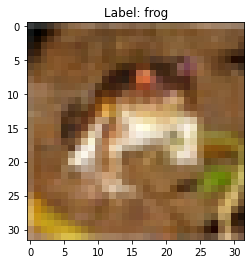

In [18]:
for i in range(1):
    image, label = train_sub_ds[i]
    plt.imshow(image)
    plt.title(f"Label: {C.target[label]}")
    plt.show()

## Transform

In [19]:
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(C.size, C.size),
                RandomResizedCrop(C.size, C.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(C.size, C.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

In [20]:
train_sub_ds = Subset(train_ds, sub_ds_idx, get_transforms(data="train"))

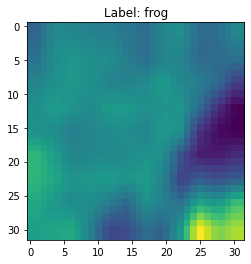

In [21]:
for i in range(1):
    image, label = train_sub_ds[i]
    plt.imshow(image[0])
    plt.title(f"Label: {C.target[label]}")
    plt.show()

## Model

In [22]:
class Net(nn.Module):
    def __init__(self, model_name="tf_efficientnet_b0_ns", pretrained=False):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, C.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
net = Net()

train_loader = DataLoader(
    train_sub_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=True
)

for image, label in train_loader:
    output = net(image)
    print(output)
    break

tensor([[ 0.1592, -0.1075,  0.1915,  0.3640,  0.0916,  0.2570,  0.3370, -0.8907,
          0.3022, -0.1149],
        [ 0.0879,  0.1010,  0.4889, -0.1221, -0.2158,  0.0166,  0.0385,  0.0911,
         -0.0902,  0.0028],
        [ 0.3087,  0.2091,  0.0376,  0.2858, -0.0127,  0.5627, -0.5454, -0.1313,
          0.1374, -0.0499],
        [ 0.0491,  0.0274,  0.0170, -0.5541, -0.1561,  0.2113, -0.5014,  0.0432,
         -0.0619,  0.1701]], grad_fn=<AddmmBackward>)


## Loss function

In [24]:
def get_criterion():
    if C.criterion == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss()
    return criterion

## Optimizer

In [25]:
def get_optimizer(net):
    if C.optimizer == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=C.lr, momentum=0.9)
    elif C.optimizer == "Adam":
        optimizer = Adam(net.parameters(), lr=C.lr, weight_decay=C.weight_decay, amsgrad=False)

    return optimizer

## Scheduler

In [26]:
def get_scheduler(optimizer):
    if C.scheduler == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(
            optimizer, mode="min", factor=C.factor, patience=C.patience, verbose=True, eps=C.eps
        )

    elif C.scheduler == "CosineAnnealingLR":
        scheduler = CosineAnnealingLR(optimizer, T_max=C.T_max, eta_min=C.min_lr, last_epoch=-1)

    elif C.scheduler == "CosineAnnealingWarmRestarts":
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.T_0, T_mult=1, eta_min=C.min_lr, last_epoch=-1)

    return scheduler

## Training Helper

In [27]:
def train_fn(loader, net, criterion, optimizer, scheduler, epoch, device):
    losses = AverageMeter()
    scores = AverageMeter()

    # switch to train mode
    net.train()

    start = time.time()

    for step, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        preds = net(images.float())

        loss = criterion(preds, labels)
        losses.update(loss.item(), batch_size)

        score = get_score(labels.to("cpu").detach().clone().numpy(), preds.softmax(1).argmax(1).to("cpu").detach().clone().numpy())
        scores.update(score.item(), batch_size)

        if C.gradient_accumulation_steps > 1:
            loss = loss / C.gradient_accumulation_steps
        loss.backward()

        # 学習の間、(勾配が) 急上昇するのを防ぐために総ての勾配を一緒にスケールする
        grad_norm = torch.nn.utils.clip_grad_norm_(net.parameters(), C.max_grad_norm)

        if (step + 1) % C.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if C.scheduler_batch_update:
                scheduler.step()

        if step % C.print_freq == 0 or step == (len(loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(loader)}] "
                + f"Elapsed {timeSince(start, float(step + 1) / len(loader)):s} "
                + f"Score: {scores.avg:.4f} "
                + f"Loss: {losses.avg:.4f} "
                + f"Grad: {grad_norm:.4f} "
                # + f"LR: {scheduler.get_lr()[0]:.6f} "  # optimizer.param_groups[0]['lr']
            )

    return scores.avg, losses.avg

In [28]:
def valid_fn(loader, net, criterion, device):
    losses = AverageMeter()
    scores = AverageMeter()
    preds_all = []

    # switch to evaluation mode
    net.eval()

    start = time.time()

    for step, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            preds = net(images.float())

        loss = criterion(preds, labels)
        losses.update(loss.item(), batch_size)

        score = get_score(labels.to("cpu").numpy(), preds.softmax(1).argmax(1).to("cpu").numpy())
        scores.update(score.item(), batch_size)

        preds_all.append(preds.softmax(1).to("cpu").numpy())

        if step % C.print_freq == 0 or step == (len(loader) - 1):
            print(
                f"EVAL: [{step}/{len(loader)}] "
                + f"Elapsed {timeSince(start, float(step + 1) / len(loader)):s} "
                + f"Score: {scores.avg:.4f} "
                + f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds_all)
    return scores.avg, losses.avg, predictions

In [29]:
def train_loop(folds, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = Subset(train_ds, trn_idx, transform=get_transforms(data="train"))
    valid_dataset = Subset(train_ds, val_idx, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=C.batch_size,
        shuffle=True,
        num_workers=C.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=C.batch_size,
        shuffle=False,
        num_workers=C.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # model
    # ====================================================
    net = Net(C.model_name, pretrained=True)
    net.to(device)

    criterion = get_criterion()
    optimizer = get_optimizer(net)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(C.n_epoch):
        start_time = time.time()

        score_avg, loss_avg = train_fn(train_loader, net, criterion, optimizer, scheduler, epoch, device)
        
        val_score_avg, val_loss_avg, preds = valid_fn(valid_loader, net, criterion, device)
        val_labels = valid_folds[C.target_col].values
        
        if not C.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss_avg)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()
        
        score = get_score(val_labels, preds.argmax(1))
        
        elapsed = time.time() - start_time
        
        LOGGER.info(
            f"Epoch {epoch+1} - "
            + f"train_score: {score_avg:.4f} "
            + f"val_score: {val_score_avg:.4f} "
            + f"train_loss: {loss_avg:.4f} "
            + f"val_loss: {val_loss_avg:.4f} "
            + f"time: {elapsed:.0f}s"
        )
        # LOGGER.info(f"Epoch {epoch+1} - Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": net.state_dict(), "preds": preds}, OUTPUT_DIR + f"{C.model_name}_{C.model_index[fold]}_best.pth"
            )
            
    check_point = torch.load(OUTPUT_DIR + f"{C.model_name}_{C.model_index[fold]}_best.pth")
    valid_folds[[str(c) for c in range(C.target_size)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds    

## Inference Helper

In [30]:
def inference(net, states, loader, device):
    net.to(device)
    probs = []
    
    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        avg_preds = []

        for state in states:
            net.load_state_dict(state["model"])
            net.eval()
            
            with torch.no_grad():
                preds = net(images.float())
                
            avg_preds.append(preds.softmax(1).to("cpu").numpy())
            
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
        
    probs = np.concatenate(probs)
    return probs

In [31]:
def score_by_class(labels, preds):
    pred_df = pd.DataFrame({'label': labels, 'pred': preds}, columns=['label', 'pred'])
    for i in range(C.target_size):
        class_idx = pred_df[pred_df["label"] == i].index
        score = get_score(pred_df.loc[class_idx, "label"], pred_df.loc[class_idx, "pred"])
        LOGGER.info(f"Class: {C.target[i]:5s} Score: {score:<.5f}")

## Main

In [32]:
def main():

    if C.train:
        oof_df = pd.DataFrame()

        for fold in range(C.n_fold):
            _oof_df = train_loop(folds, fold)
            oof_df = pd.concat([oof_df, _oof_df])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)

        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if C.inference:
        net = Net(C.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{C.model_name}_{idx}_best.pth") for idx in C.model_index]
        
        test_dataset = Subset(test_ds, range(len(test_ds)), transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=C.batch_size, shuffle=False, num_workers=C.num_workers, pin_memory=True
        )
        
        predictions = inference(net, states, test_loader, device)
        
        score = get_score(test_ds.targets, np.argmax(predictions, axis=1))

        LOGGER.info(f"========== Inference ==========")
        LOGGER.info(f"Score: {score:.4f}")

        score_by_class(test_ds.targets, np.argmax(predictions, axis=1))

        cm = confusion_matrix(np.argmax(predictions, axis=1), test_ds.targets)
        cm_labeled = pd.DataFrame(cm, columns=C.target, index=C.target)

        LOGGER.info(f"========== Confusion Matrix ==========")
        seaborn.heatmap(cm_labeled, cmap='Blues')

========== fold: 0 training ==========


Epoch: [1][0/66] Elapsed 0m 0s (remain 1m 2s) Score: 0.1180 Loss: 2.3942 Grad: 2.6562 
Epoch: [1][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.2458 Loss: 2.1360 Grad: 2.0630 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 14s) Score: 0.4080 Loss: 1.8044 


Epoch 1 - train_score: 0.2458 val_score: 0.3917 train_loss: 2.1360 val_loss: 1.8299 time: 14s
Epoch 1 - Save Best Score: 0.3917 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.3917 Loss: 1.8299 
Epoch: [2][0/66] Elapsed 0m 0s (remain 0m 49s) Score: 0.3720 Loss: 1.8983 Grad: 2.2196 
Epoch: [2][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.4170 Loss: 1.7171 Grad: 2.1248 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 17s) Score: 0.5040 Loss: 1.4353 


Epoch 2 - train_score: 0.4170 val_score: 0.4894 train_loss: 1.7171 val_loss: 1.4646 time: 14s
Epoch 2 - Save Best Score: 0.4894 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.4894 Loss: 1.4646 


========== fold: 0 result ==========
Score: 0.4894
========== fold: 1 training ==========


Epoch: [1][0/66] Elapsed 0m 0s (remain 0m 52s) Score: 0.0960 Loss: 2.3613 Grad: 2.5602 
Epoch: [1][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.2515 Loss: 2.1259 Grad: 2.3828 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 17s) Score: 0.4200 Loss: 1.7773 


Epoch 1 - train_score: 0.2515 val_score: 0.3900 train_loss: 2.1259 val_loss: 1.8091 time: 14s
Epoch 1 - Save Best Score: 0.3900 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.3900 Loss: 1.8091 
Epoch: [2][0/66] Elapsed 0m 0s (remain 0m 53s) Score: 0.3180 Loss: 1.9287 Grad: 1.8210 
Epoch: [2][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.4222 Loss: 1.6927 Grad: 2.1526 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 14s) Score: 0.5180 Loss: 1.4346 


Epoch 2 - train_score: 0.4222 val_score: 0.4909 train_loss: 1.6927 val_loss: 1.4499 time: 14s
Epoch 2 - Save Best Score: 0.4909 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.4909 Loss: 1.4499 


========== fold: 1 result ==========
Score: 0.4909
========== fold: 2 training ==========


Epoch: [1][0/66] Elapsed 0m 0s (remain 0m 51s) Score: 0.0840 Loss: 2.3446 Grad: 2.2473 
Epoch: [1][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.2466 Loss: 2.1420 Grad: 2.0691 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 18s) Score: 0.3220 Loss: 1.8810 


Epoch 1 - train_score: 0.2466 val_score: 0.3871 train_loss: 2.1420 val_loss: 1.8561 time: 14s
Epoch 1 - Save Best Score: 0.3871 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.3871 Loss: 1.8561 
Epoch: [2][0/66] Elapsed 0m 0s (remain 0m 52s) Score: 0.3880 Loss: 1.8963 Grad: 2.0757 
Epoch: [2][65/66] Elapsed 0m 10s (remain 0m 0s) Score: 0.4193 Loss: 1.7136 Grad: 2.0609 
EVAL: [0/34] Elapsed 0m 0s (remain 0m 17s) Score: 0.4720 Loss: 1.4958 


Epoch 2 - train_score: 0.4193 val_score: 0.4938 train_loss: 1.7136 val_loss: 1.4556 time: 14s
Epoch 2 - Save Best Score: 0.4938 Model


EVAL: [33/34] Elapsed 0m 2s (remain 0m 0s) Score: 0.4938 Loss: 1.4556 


========== fold: 2 result ==========
Score: 0.4938
========== CV ==========
Score: 0.4914
========== Inference ==========
Score: 0.5062
Class: plane Score: 0.63000
Class: car   Score: 0.68700
Class: bird  Score: 0.22400
Class: cat   Score: 0.16600
Class: deer  Score: 0.42600
Class: dog   Score: 0.48300
Class: frog  Score: 0.71600
Class: horse Score: 0.55500
Class: ship  Score: 0.55900
Class: truck Score: 0.61600
========== Confusion Matrix ==========


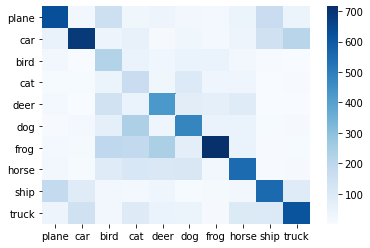

In [33]:
if __name__ == "__main__":
    main()

In [34]:
!nvidia-smi

Wed Mar  3 12:15:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    44W /  70W |   2092MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------